In [1]:
using Pkg; Pkg.instantiate(); Pkg.precompile()

Precompiling project...


In [2]:
using Random; Random.seed!(1234);

# Directional variograms

In this tutorial, we demonstrate how empirical variograms can be computed along a specific direction (a.k.a. *directional variograms*). This computation is extremely efficient in GeoStats.jl and can be performed in less than a second with many thousands of spatial data points arranged in arbitrary locations.

## Synthetic data

In order to illustrate the functionality, we create synthetic data with predefined anisotropy. Later on in this tutorial, we will pretend that we don't know the anisotropy ratio and will then try to discover it with directional variograms. Here, we generate Gaussian realizations as follows.

First, we consider a base (isotropic) variogram model:

In [3]:
using GeoStats

γ = GaussianVariogram(range=10.)

GaussianVariogram{Float64,Distances.Euclidean}
  range: Float64 10.0
  sill: Float64 1.0
  nugget: Float64 1.0e-6
  distance: Distances.Euclidean


To convert this isotropic model into an anisotropic model, we use an ellipsoid distance. Given that the range of the variogram is $10$, we will stretch the $x$ axis by a factor of $3$ to produce an effective horizontal range of $30$, and the $y$ axis by a factor of $1$, which will leave the vertical range untouched and equal to $10$. We set the angle of the ellipsoid to $0$ so that the anisotropy is aligned with the coordinate system:

In [4]:
γ = GaussianVariogram(range=10., distance=Ellipsoidal([3.,1.], [0.]))

GaussianVariogram{Float64,Ellipsoidal{2,Float64}}
  range: Float64 10.0
  sill: Float64 1.0
  nugget: Float64 1.0e-6
  distance: Ellipsoidal{2,Float64}


With this anisotropic model, we generate $3$ realizations using direct Gaussian simulation:

In [5]:
using DirectGaussianSimulation

Random.seed!(2021)

problem = SimulationProblem(RegularGrid(100,100), :Z=>Float64, 3)

solver  = DirectGaussSim(:Z=>(variogram=γ,))

solution = solve(problem, solver)

2D SimulationSolution
  domain: 100×100 RegularGrid{Float64,2}
  variables: Z
  N° reals:  3

We observe that the "blobs" in the realizations are indeed stretched horizontally, and that they approximately fit into bounding boxes of size $30\times 10$:

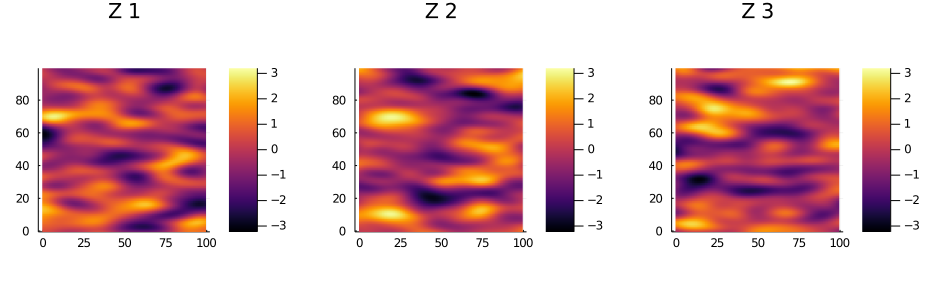

In [6]:
using Plots; gr(size=(950,300))

plot(solution)

We will now use one of these realizations as our spatial data, and will pretend that we don't know the anisotropy ratio of $30 / 10 = 3$:

In [7]:
𝒮 = solution[1]

100×100 RegularGrid{Float64,2}
  variables
    └─Z (Float64)

## Variogram calculations

We estimate the horizontal and vertical variograms from the data:

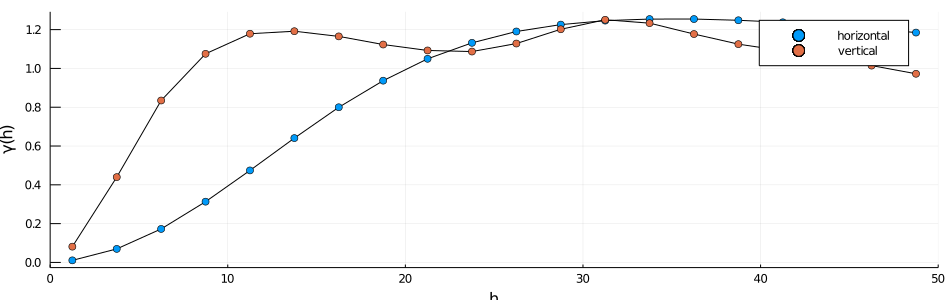

In [8]:
γhor = DirectionalVariogram((1.,0.), 𝒮, :Z, maxlag=50.)
γver = DirectionalVariogram((0.,1.), 𝒮, :Z, maxlag=50.)

plot(γhor, showbins=false, label="horizontal")
plot!(γver, showbins=false, label="vertical")

The plot shows clearly that the horizontal and vertical ranges are approximately $30$ and $10$, which is a satisfactory result (we know the correct answer). Finally, we can fit theoretical variogram models and estimate the anisotropy ratio:

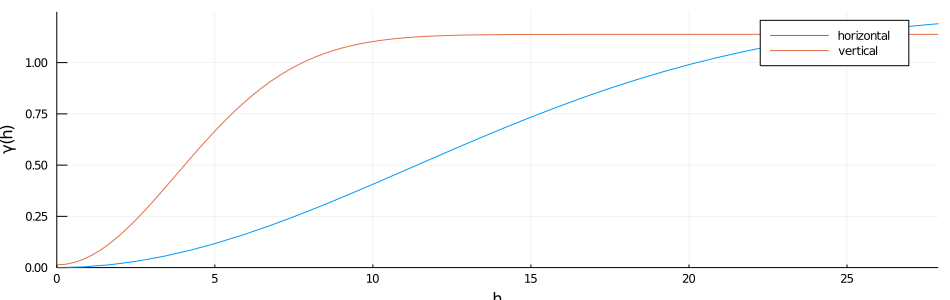

In [9]:
γₕ = fit(GaussianVariogram, γhor)
γᵥ = fit(GaussianVariogram, γver)

plot(γₕ, label="horizontal")
plot!(γᵥ, label="vertical")

In [10]:
ratio = range(γₕ) / range(γᵥ)

2.967428160420111

## Varioplanes

In the previous section, we focused our attention to two major directions $(1,0)$ and $(0,1)$, and noticed that the  horizontal direction $(1,0)$ had a larger range when compared to the vertical direction $(0,1)$. Alternatively, we can investigate all possible directions in a single plot known as the *varioplane*.

In this plot, we compute the empirical variogram for all angles $\theta \in [0,2\pi]$, and optionally estimate the ranges:

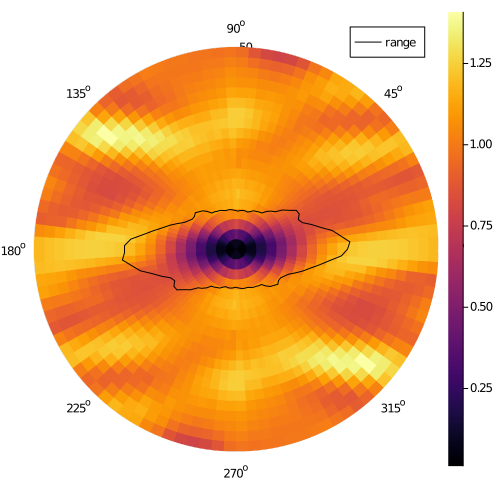

┌ Warning: Right now only the maximum value of y (r) is taken into account.
└ @ Plots /home/juliohm/.julia/packages/Plots/6RLiv/src/backends/gr.jl:1757


In [11]:
γₚ = EmpiricalVarioplane(𝒮, :Z, maxlag=50.)

plot(γₚ, size=(500,500))

As can be seen from the plot, the major direction of correlation is horizontal $range(0^\circ) \approx 30$ and the minor direction of correlation is vertical $range(90^\circ) \approx 10$. All other directions have ranges in between these two extremes $10 \le range(\theta) \le 30$.

## Conclusions

- Directional variograms can be computed very efficiently in GeoStats.jl with any spatial data (e.g. point set data, regular grid data)

- They are useful to estimate anisotropy, particularly when a clear image is not available showing "blobs", but only sparse samples

- Variogram plane plots give a good overview of the ranges as a function of direction, for all directions in a plane